In [3]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import copy

In [4]:
data = pd.read_csv('dataset\dataset.tsv', delimiter = '\t')
print(list(data.columns.values))
df = pd.DataFrame(data).T
df2 = df.T

['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'y']


In [5]:
# data mapping function check
x2_mapping_data = {label:idx for idx, label in enumerate(np.unique(df2['x2']))}
x3_mapping_data = {label:idx for idx, label in enumerate(np.unique(df2['x3']))}
x4_mapping_data = {label:idx for idx, label in enumerate(np.unique(df2['x4']))}
x5_mapping_data = {label:idx for idx, label in enumerate(np.unique(df2['x5']))}
x7_mapping_data = {label:idx for idx, label in enumerate(np.unique(df2['x7']))}
x8_mapping_data = {label:idx for idx, label in enumerate(np.unique(df2['x8']))}
x9_mapping_data = {label:idx for idx, label in enumerate(np.unique(df2['x9']))}
x11_mapping_data = {label:idx for idx, label in enumerate(np.unique(df2['x11']))}
x15_mapping_data = {label:idx for idx, label in enumerate(np.unique(df2['x15']))}
y_mapping_data = {label:idx for idx, label in enumerate(np.unique(df2['y']))}

## 데이터 전처리 - 1
 - 문자 데이터를 정수형 데이터로 변환 : df2

In [6]:
# 범주형 데이터 정수 맵핑
# 상기 mapping_data를 DEFAULT로 사용. 순서가 필요하거나 개념상 헷갈릴 수 있는 부분은 매뉴얼리 수정하여 적용
# 결측치 제거: unknown 및 -1 제거 >> 제거하면 유의미한 데이터가 많이(32484개씩 사라지는 column 존재) 사라지므로 unknown을 0으로 맵핑하여 사용한다.

x2_mapping = {
    'unknown': 0,
    'admin.' : 1,
    'unemployed' : 2,
    'management' : 3,
    'housemaid' : 4,
    'entrepreneur': 5,
    'student': 6,
    'blue-collar' : 7,
    'self-employed': 8,
    'retired':9,
    'technician':10,
    'services':11
}
x3_mapping = { 'married': 0, 'divorced': 1, 'single': 2 }
x4_mapping = {'unknown': 0, '저학력': 1, '중학력': 2, '고학력': 3}
x578_mapping = {'no': 0, 'yes':1}
x9_mapping = {'unknown': 0, '유선':1, '무선':2 }
x11_mapping = {
    'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12
}
x15_mapping = {'unknown':0, 'failure':1, 'success':2, 'other':3 }
y_mapping ={'no':0, 'yes':1}

df2['x2'] = df2['x2'].map(x2_mapping)
df2['x3'] = df2['x3'].map(x3_mapping)
df2['x4'] = df2['x4'].map(x4_mapping)
df2['x5'] = df2['x5'].map(x578_mapping)
df2['x7'] = df2['x7'].map(x578_mapping)
df2['x8'] = df2['x8'].map(x578_mapping)
df2['x9'] = df2['x9'].map(x9_mapping)
df2['x11'] = df2['x11'].map(x11_mapping)
df2['x15'] = df2['x15'].map(x15_mapping)
df2['y'] = df2['y'].map(y_mapping)

df2.to_csv("quantize_alldata.csv",mode = 'w')

######## data 원래대로 reverse하는법
#### inv_x2_mapping = {v: k for k, v in x2_mapping.items()}
#### df2['x2'] = df2['x2'].map(inv_x2_mapping)

## 데이터 전처리 - 2
 - 범주형 변수의 경우 dummy를 사용해서 바꿔줌 (x2, x3) 
 - x2 >> x2_admin, x2_unemployed, x2_management, x2_housemaid, x2_entrepreneur, x2_ ...
 - 클러스터 사용할 때는 범주형 변수는 input에서 제외한다 (클러스터 실험결과 이 경우 설명력이 오히려 떨어짐) --> df_new2

In [7]:
df_new = copy.deepcopy(df2)

# x2, x3을 dummy로 만들어서 정의
df2_x2 = pd.get_dummies(df_new['x2'], prefix='x2')
df2_x3 = pd.get_dummies(df_new['x3'], prefix='x3')

# x2, x3을 기존 dataframe에서 제외
del df_new['x2']
del df_new['x3']
del df_new['y']

# x2, x3 대신 dummy x2, x3을 병합
df_new2 = pd.concat([df_new, df2_x2, df2_x3], axis=1)
df_new2['y'] = df2['y']
df_new2.to_csv("quantize_dummy_data.csv",mode = 'w')

## 데이터 전처리 - 3
  - 데이터 정규화 (클러스터링을 할 때: Problem #1 )
  - 데이터 표준화 (logistic regression을 할 때: problem #2)

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from pandas import DataFrame

#### 정규화
stdscaler = StandardScaler()
scaled_data = stdscaler.fit_transform(df_new2.loc[:,'x1':'y']) ## for cluster
column_names = df_new2.columns
df_scale = DataFrame(data=scaled_data, columns = column_names)

#### 표준화 (해당 데이터는 이번 파일이 아닌 문제2번에서 tensorflow input으로 사용한다)
mmscaler = MinMaxScaler()
scaled_data = mmscaler.fit_transform(df_new2.loc[:,'x1':'x3_2'])
column_names = df_new2.columns
data_for_learning = DataFrame(data=scaled_data)
data_for_learning['y'] = df_new2['y']
data_for_learning.columns = column_names
#data_for_learning.to_csv("data_for_learning.csv",mode = 'w')
#scaled_data

## 데이터 전처리 - 4
 - 표준화한 데이터를 training, test로 나누어서 저장

In [12]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_for_learning, test_size = 0.3, random_state = 42)
train.to_csv("data_for_training.csv",mode = 'w')
test.to_csv("data_for_test.csv",mode = 'w')

# 클러스터 (PCA 이후 K-means)
## PCA >> 차원축소
 - PCA(주성분 분석
   : 약 80% 이상을 설명할 수 있는 인자들을 선택 (클러스터 계산 시 연산 속도 개선)
   : 8개의 eigen vector 중에 몇개를 선택할 지 threshold를 잡음 (eigen value가 높은 녀석들 중 순서대로 eigen vector를 활용)
 
 - print 결과 분석 : 79%를 2개의 pca 차원으로 설명 가능

In [30]:
scaled_input = scaled_data[:,[0,1,2,3,4,5]] # x1, x4, x5, x6, x7, x8의 input만 사용
#scaled_input = scaled_data[:,[0,1,2,3,4,5,6,7,14,15,16,17,18,19,20,21,22,23,24,25,26,27]] # x1~x8의 input 모두 사용
features = scaled_input.T
covariance_matrix = np.cov(features)
eig_vals, eig_vecs = np.linalg.eig(covariance_matrix)
# eig value의 설명 분산 비율
tot = sum(eig_vals)
var_exp = [(i / tot) for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)
## 2개 dim으로 약 80% 설명 가능 (pc1, pc2 2개만 가지고 클러스터링) pc1 >> 53%, pc1 + pc2 >> 79%, pc1+pc2+pc3 >> 94%

[0.53079367 0.79364576 0.94100786 0.9788908  0.9980195  1.        ]


## PCA 로 축소한 데이터를 K-means에 활용
 - 적합한 K값을 선택하기 위해 1~30개의 cluster를 만들어보고 SSE 값의 추이를 관찰 (saturation 되는 지점을 k값으로 잡는다)
 - 그래프 결과 4개의 클러스터로 묶는것이 적합해 보임

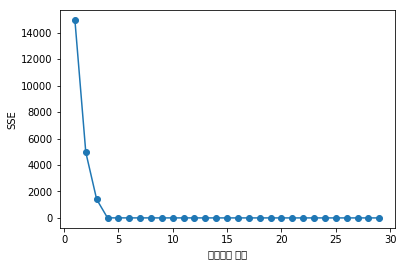

In [31]:
from sklearn import metrics
from sklearn import decomposition
from sklearn.cluster import KMeans
from time import time

pca1 = decomposition.PCA(n_components=2)
sklearn_pca= pca1.fit_transform(scaled_input)
sklearn_result_pc = pd.DataFrame(sklearn_pca, columns = ['pc1', 'pc2']) # 총 2차원으로 데이터 변환

# PCA를 사용하여 축소한 데이터를 사용
# k-means에서  K의 값은 SSE의 추이를 그래프로 보고 선택한다.
def elbow(X):
    sse = []
    max_cluster = 30
    for i in range(1, max_cluster):
        km = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
        km.fit(X)
        sse.append(km.inertia_)
    plt.plot(range(1, max_cluster), sse, marker='o')
    plt.xlabel('클러스터 개수')
    plt.ylabel('SSE')
    plt.show()

elbow(sklearn_pca)

## 클러스터 성능 평가
  : 정답지가 있을 때 ARI 를 통해 클러스터의 성능을 평가할 수 있다. 
   - k=2일때 정답지와 비교하면 약 0.02 --> 1에 가까울수록 좋은 성능. 즉, 2개의 클러스터로는 설명이 불가능에 가까움
  
  : 정답지가 없을 때 실루엣 스코어를 통해 클러스터의 성능을 평가할 수 있다.
   - 즉, 이번 클러스터 성능평가는 실루엣 스코어를 통해 확인해야 함

In [32]:
# 클러스터의 개수를 2로 하고 정답지와 비교해봄 >> ARI 
from sklearn.metrics.cluster import adjusted_rand_score
km_2 = KMeans(n_clusters=2, init='k-means++', random_state = 0).fit(sklearn_pca)
str_temp = "cluster_2"
adjusted_rand_score(km_2.labels_, df_new2['y'])

0.019870326796072438